# Malaria Image Classification Project
This project uses a convolutional neural network (CNN) to classify cell images as Parasitized (Infected) or Uninfected based on a publicly available malaria dataset. The goal is to assist in the early detection of malaria infection from microscopic blood smear images using deep learning.

## Import Required Libraries

In [ ]:
# Data visualization and analytics
import matplotlib.pyplot as plt # Plot graphs and images
import numpy as np              # Handle arrays and numerical data
import seaborn as sns           # Generate heatmaps and styled plots

# Evaluation metrics
from sklearn.metrics import confusion_matrix, classification_report

# File and image processing
import os   # Work with file paths
import cv2  # Image loading and resizing

# TensorFlow / Keras modules for building CNN
from tensorflow.keras.preprocessing.image import ImageDataGenerator                # Image augmentation
from tensorflow.keras.models import Sequential                                     # Model type (sequential layers)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout  # Layers for CNN
from tensorflow.keras.callbacks import EarlyStopping                               # Stop training early if overfitting

## Dataset Setup
In this section, we will download the Malaria Cell Images dataset directly from Kaggle into our Colab environment.
The dataset contains two categories of cell images:
*   Parasitized (Infected with Malaria)
*   Uninfected



In [ ]:
# Import the 'files' module to upload files to Colab
from google.colab import files
files.upload() # Upload your Kaggle API token (kaggle.json)

# Create a hidden directory for Kaggle configuration
!mkdir -p ~/.kaggle

# Move kaggle.json to the Kaggle directory
!mv kaggle.json ~/.kaggle/

# Set permissions to ensure the Kaggle API can read the file securely
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


## Download the Malaria Dataset
The dataset used here is "cell-images-for-detecting-malaria" by iarunava on Kaggle. It contains over 27,000 images of infected and uninfected cells.

In [ ]:
# Download the Malaria dataset from Kaggle
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

# Unzip the downloaded dataset into a new directory named 'malaria_data'
!unzip cell-images-for-detecting-malaria.zip -d ./malaria_data

# Check the contents of the extrated folder
os.listdir('./malaria_data')

Streaming output truncated to the last 5000 lines.
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_116.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_118.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_126.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_134.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_141.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_168.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_175.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127_102428_cell_183.png  
  inflating: ./malaria_data/cell_images/cell_images/Uninfected/C236ThinF_IMG_20151127

['cell_images']

## Install Python Libraries
These are the main libraries required for the project:
*   matplotlib / seaborn : Data visualization
*   numpy / scikit-learn : Numerical operations and evaluation metrics
*   tensorflow / keras   : Deep learning model building
*   opencv-python        : Image processing





In [ ]:
%pip install matplotlib opencv-python tensorflow keras numpy scikit-learn seaborn

## Data Exploration
In this section, we will:
1.   List all images in the Parasitized and Uninfected folders
2.   Display example images to understand the dataset



Number of Parasitized images: 13780
Number of Uninfected images: 13780


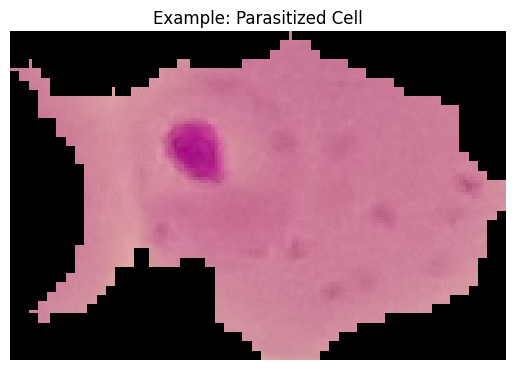

In [ ]:
# List all images in each category
parasitized = os.listdir('./malaria_data/cell_images/Parasitized')
uninfected = os.listdir('./malaria_data/cell_images/Uninfected')

print(f"Number of Parasitized images: {len(parasitized)}")
print(f"Number of Uninfected images: {len(uninfected)}")

# Display an example image from the Parasitized class
img_path = './malaria_data/cell_images/Parasitized/' + parasitized[0]
img = cv2.imread(img_path)

# Convert from BGR (OpenCV default) to RGB for correct plotting
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# SDhow the image
plt.imshow(img_rgb)
plt.title("Example: Parasitized Cell")
plt.axis('off')
plt.show()

## Data Preprocessing and Augmentation
We use Keras' ImageDataGenerator to:
1.   Normalize pixel values (rescale from 0-255 to 0-1)
2.   Perform real-time data augmentation to improve generalization
3.   Split data into training (80%) and validation (20%)








In [ ]:
# Training data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Normalize pixel values
    rotation_range=20,        # Randomly rotate images by up to 20 degrees
    width_shift_range=0.1,    # Shift images horizontally by up to 10%
    height_shift_range=0.1,   # Shift images vertically by up to 10%
    shear_range=0.2,          # Shear transformations
    zoom_range=0.1,           # Zoom in/out randomly
    horizontal_flip=True,     # Flip images horizontally
    fill_mode='nearest',      # Fill in new pixels after transformations
    validation_split=0.2      # Reserve 20% of data for validation
)

# Validation Data Generator
val_datagen = ImageDataGenerator(
    rescale=1./255,           # Only normalize pixel values for validation
    validation_split=0.2
)

# Create Training Dataset Generator
train = train_datagen.flow_from_directory(
    './malaria_data/cell_images/cell_images', # Path to dataset
    target_size=(128,128),                    # Resize all images to 128x128 pixels
    batch_size=32,                            # Number of images per batch
    class_mode='binary',                      # Binary classification: Parasitized vs Uninfected
    subset='training',                        # Uses 80% of images for training
    shuffle=True                              # Shuffle images each epoch
)

# Create Validation Dataset Generator
val = val_datagen.flow_from_directory(
    './malaria_data/cell_images/cell_images',
    target_size=(128,128),
    batch_size=32,
    class_mode='binary',
    subset='validation',                      # Uses 20% of images for validation
    shuffle=False                             # No need to shuffle for validation
    )

Found 22048 images belonging to 2 classes.
Found 5510 images belonging to 2 classes.


## Build and Train the CNN Model
This section creates a simple Convolutional Neural Network (CNN) to classify malaria-infected vs uninfected cells. EarlyStopping is used to prevent overfitting.

In [ ]:
# Early Stopping Callback
early_stop = EarlyStopping(
    monitor='val_loss',         # Monitor the validation loss
    patience=3,                 # Stop training if val_loss does not improve for 3 epochs
    restore_best_weights=True   # Restore model weights from the epoch with the best val_loss
)

# Build the CNN Model
model = Sequential([
    # 1st Convolutional Layer
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3)),
    MaxPooling2D(2,2), # Downsample feature maps by 2x2

    # 2nd Convolutional Layer
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    # Flatten to 1D vector for Dense layers
    Flatten(),

    # Fully connected layer
    Dense(128, activation='relu'),
    Dropout(0.5),     # Dropout to prevent overfitting

    # Output layer for binary classification
    Dense(1, activation='sigmoid')
])

# Compile the Model
model.compile(
    optimizer='adam',           # Adaptive optimizer
    loss='binary_crossentropy', # Binary classification loss
    metrics=['accuracy']        # Track accuracy during training
)

# Train the Model
history = model.fit(
    train,                  # Training data generator
    validation_data=val,    # Validation data generator
    epochs=30,              # Max number of epochs
    callbacks=[early_stop]  # Stop early if validation loss stops improving
)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 612s 885ms/step - accuracy: 0.5993 - loss: 0.6938 - val_accuracy: 0.9299 - val_loss: 0.2486
Epoch 2/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 605s 878ms/step - accuracy: 0.9014 - loss: 0.3163 - val_accuracy: 0.8967 - val_loss: 0.2432
Epoch 3/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 623s 879ms/step - accuracy: 0.9224 - loss: 0.2441 - val_accuracy: 0.9354 - val_loss: 0.1899
Epoch 4/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 613s 866ms/step - accuracy: 0.9230 - loss: 0.2306 - val_accuracy: 0.9343 - val_loss: 0.1887
Epoch 5/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 607s 882ms/step - accuracy: 0.9271 - loss: 0.2209 - val_accuracy: 0.9341 - val_loss: 0.1789
Epoch 6/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 604s 876ms/step - accuracy: 0.9293 - loss: 0.2049 - val_accuracy: 0.9361 - val_loss: 0.1753
Epoch 7/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 607s 880ms/step - accuracy: 0.9322 - loss: 0.1968 - val_accuracy: 0.9352 - val_loss: 0.1718
Epoch 8/30
689/689 ━━━━━━━━━━━━━━━━━━━━ 614s 891ms/step - accuracy: 0.9327 -

## Model Evaluation and Visualization
Evaluate the trained CNN on the validation set.
Generate confusion matrix, classification report, and accuracy/loss plots.

In [ ]:
# Evaluate Model on Validation Data
val_loss, val_acc = model.evaluate(val)
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}")
print("\n")

# Predict on Validation Data
# model.predict returns probabilities (0 to 1)
y_pred_probs = model.predict(val, steps=len(val))
y_pred = (y_pred_probs > 0.5).astype("int32").ravel() # Convert probabilities to 0 or 1

# True labels from the validation generator
y_true = val.classes

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot it
plt.figure(figsize=(6,5))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Uninfected','Parasitized'],
    yticklabels=['Uninfected','Parasitized']
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Uninfected','Parasitized']))

# Plot Training History
plt.figure(figsize=(12,4))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Save the Trained Model

In [ ]:
# Save the model
model.save('malaria_model.keras')
print('Successfully saved model!')

# Download the saved model to your local machine
files.download('malaria_model.keras')